Data Preparation

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Logistic Regression:
Accuracy: 0.8581346910437399
Precision: 0.8766645529486367
Recall: 0.9250585480093677
Random Forest:
Accuracy: 0.8666975237213608
Precision: 0.8674992385013707
Recall: 0.9528270324523251


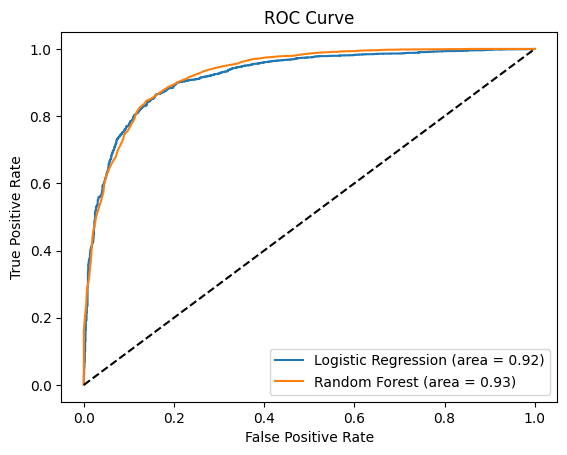

In [15]:
import nltk
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt

nltk.download('punkt')

# Load the datasets
with open('/kaggle/input/reviews-dataset/TrainingDataNegative.txt', 'r', encoding='utf-8') as file:
    negative_reviews = file.readlines()
negative_reviews = [review.strip() for review in negative_reviews]
negative_df = pd.DataFrame({'review': negative_reviews, 'sentiment': 'negative'})

with open('/kaggle/input/reviews-dataset/TrainingDataPositive.txt', 'r', encoding='utf-8') as file:
    positive_reviews = file.readlines()
positive_reviews = [review.strip() for review in positive_reviews]
positive_df = pd.DataFrame({'review': positive_reviews, 'sentiment': 'positive'})

test_reviews = pd.read_csv('/kaggle/input/reviews-dataset/TestReviews.csv')

# Map class to sentiment in test dataset
test_reviews['sentiment'] = test_reviews['class'].apply(lambda x: 'positive' if x == 1 else 'negative')

# Combine the training datasets
train_data = pd.concat([negative_df, positive_df]).reset_index(drop=True)

# Tokenize the reviews
train_data['tokens'] = train_data['review'].apply(word_tokenize)
test_reviews['tokens'] = test_reviews['review'].apply(word_tokenize)

# Install Gensim if not already installed
!pip install gensim

# Load GloVe model using Gensim
import gensim.downloader as api

# Download the GloVe model
glove_model = api.load("glove-wiki-gigaword-50")

# Function to get average word embedding using GloVe model
def get_avg_embedding(tokens):
    embeddings = [glove_model[word] for word in tokens if word in glove_model]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(glove_model.vector_size)

# Apply the function to get embeddings for each review
train_data['embedding'] = train_data['tokens'].apply(get_avg_embedding)
test_reviews['embedding'] = test_reviews['tokens'].apply(get_avg_embedding)

# Prepare data for model training
X_train = np.vstack(train_data['embedding'].values)
y_train = train_data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values
X_test = np.vstack(test_reviews['embedding'].values)
y_test = test_reviews['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values

# Train Logistic Regression and Random Forest classifiers
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Metrics for Logistic Regression
print('Logistic Regression:')
print('Accuracy:', accuracy_score(y_test, y_pred_lr))
print('Precision:', precision_score(y_test, y_pred_lr))
print('Recall:', recall_score(y_test, y_pred_lr))

# Metrics for Random Forest
print('Random Forest:')
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('Precision:', precision_score(y_test, y_pred_rf))
print('Recall:', recall_score(y_test, y_pred_rf))

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_model.predict_proba(X_test)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])

plt.figure()
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (area = %0.2f)' % auc(fpr_lr, tpr_lr))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.2f)' % auc(fpr_rf, tpr_rf))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
